Before starting working on this Python lab, install the following library with this command


In [1]:
from IPython.display import Image
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.transforms import ToTensor
from torch.optim import RMSprop
from torch.optim import Adam as tAdam

## Bayesian networks

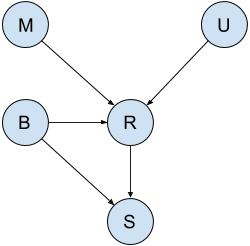

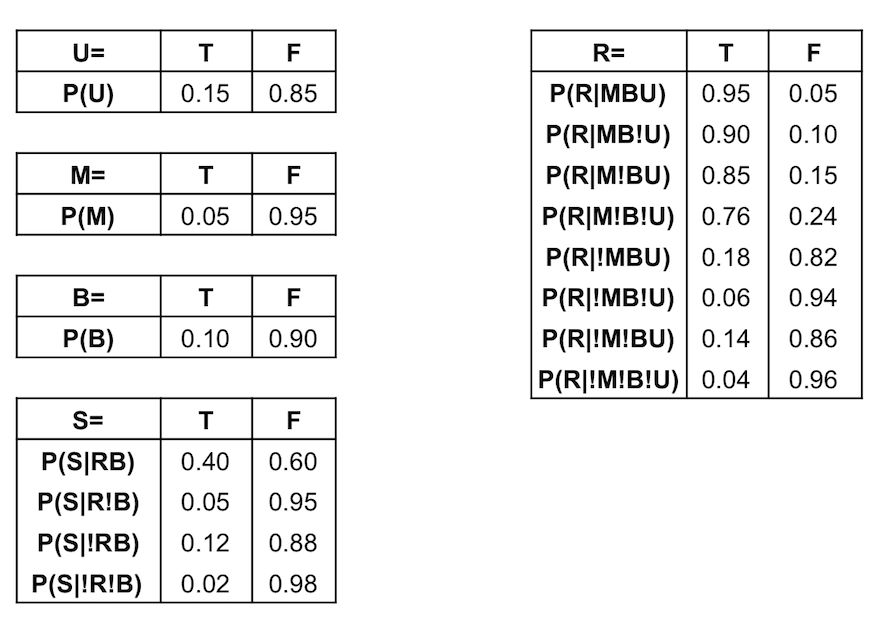

Create Bayesian network and corresponding conditional probabilities and check if model is correct.

In [2]:
model = BayesianModel([('M', 'R'), ('U', 'R'), ('B', 'R'), ('B', 'S'), ('R', 'S')])

cpd_u = TabularCPD(variable='U', variable_card=2, values=[[0.15], [0.85]])
cpd_m = TabularCPD(variable='M', variable_card=2, values=[[0.05], [0.95]])
cpd_b = TabularCPD(variable='B', variable_card=2, values=[[0.10], [0.90]])

cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.4, 0.05, 0.12, 0.02],
                           [0.6, 0.95, 0.88, 0.98]],
                  evidence=['B', 'R'],
                  evidence_card=[2, 2])

cpd_r = TabularCPD(variable='R', variable_card=2,
                   values=[[0.95, 0.90, 0.85, 0.76, 0.18, 0.06, 0.14, 0.04],
                           [0.05, 0.10, 0.15, 0.24, 0.82, 0.94, 0.86, 0.96]],
                   evidence=['M', 'U', 'B'],
                   evidence_card=[2, 2, 2])


# Associating the CPDs with the network
model.add_cpds(cpd_u, cpd_m, cpd_b, cpd_s, cpd_r)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly
# defined and sum to 1.
model.check_model()

C:\Users\Weilong Chen\AppData\Roaming\Python\Python39\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


True

Find proability of $P(R)$ and $P(R|A)$ using pgmpy. Check the output with your manual calculation.

In [3]:
infer = VariableElimination(model)
r_dist = infer.query(['R'])
print(r_dist)

+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.0901 |
+------+----------+
| R(1) |   0.9099 |
+------+----------+


In [4]:
# pretending the condition is 'ture'.
print(infer.query(['R'], evidence={'M': 0}))

+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.7894 |
+------+----------+
| R(1) |   0.2106 |
+------+----------+


Investigate at least two features in pgmpy that you find interesting, e.g., check dependencies between the variables, etc.

In [5]:
model.local_independencies('M')

(M ⟂ U, B)

In [6]:
model.active_trail_nodes('M')

{'M': {'M', 'R', 'S'}}

## Markov random fields

### Image denoising with Ising model

Text(0.5, 1.0, 'True binary image')

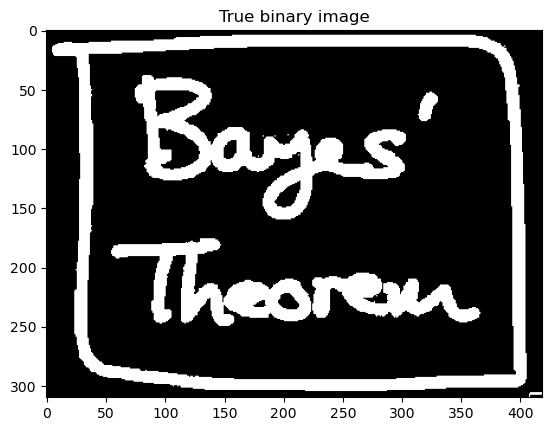

In [5]:
#load image data
data = Image.open('bayes.bmp')
temp = np.double(data)
temp_mean = np.mean(data)
clean_img = +1*(temp>temp_mean) + -1*(temp<temp_mean)

plt.figure()
plt.imshow(clean_img,cmap='Greys')
plt.title("True binary image")

310 419


Text(0.5, 1.0, 'observed noisy image')

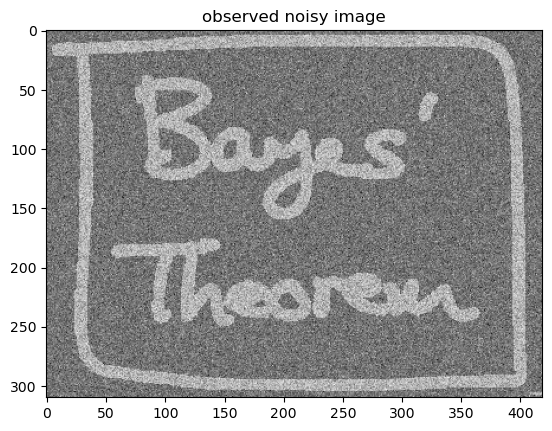

In [19]:
height,width = clean_img.shape
print(height,width)
sigma  = 0.8  #noise level
noisy_img = clean_img + sigma*np.random.randn(height, width)

plt.figure()
plt.imshow(noisy_img, cmap='Greys')
plt.title("observed noisy image")

Implement Ising model to denoise noisy image. Here, the objective is minimizing the following energy function using iterated conditional method.
$$ E(x,y) = h\sum_{i}x_{i} - \beta\sum_{i,j}x_{i}x_{j}-\eta\sum_{i}x_{i}y_{i} $$


iterated conditional method:

initialization: $x_{i}=y_{i}$ for all $i$

For $j = 1, . . . ,N$
  1. Evaluate total energy for states $x_{j} = +1$ and $x_{j} = −1$ keeping all other variables fixed.
      Set $x_{j}$ to state with lower energy.
  2. Repeat 1 until convergence or stopping criterion.
  
  
 Comapre denoised image with the original image.

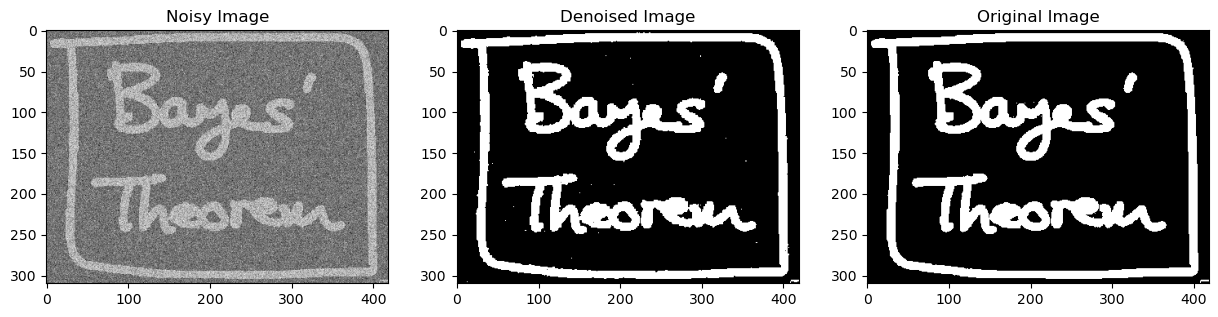

In [21]:
def neighbors(x, i, j):
    nx, ny = x.shape
    r, c = [], []
    #xi*xj neighbor values around 
    if i > 0:
        r.append(i - 1)
        c.append(j)
    if j > 0:
        r.append(i)
        c.append(j - 1)
    if i < nx - 1:
        r.append(i + 1)
        c.append(j)
    if j < ny - 1:
        r.append(i)
        c.append(j + 1)
    return r, c

def E(x, y, h, beta, eta):
    total_energy = h * x.sum() - eta * (x * y).sum()
    #$$ E(x,y) = h\sum_{i}x_{i} - \beta\sum_{i,j}x_{i}x_{j}-\eta\sum_{i}x_{i}y_{i} $$
    total_energy = 0
    nx, ny = x.shape
    for i in range(nx):
        for j in range(ny):
            rows, cols = neighbors(x, i, j)
            neighbor_energy = 0.
            for row, col in zip(rows, cols):
                neighbor_energy = neighbor_energy + x[row, col] * x[i, j]
            total_energy = total_energy - beta * neighbor_energy - eta * x[i, j] * y[i, j]     
    return total_energy


def neighbor_energy(x, i, j, beta):
    rows, cols = neighbors(x, i, j)
    energy = 0.
    for row, col in zip(rows, cols):
        energy = energy + x[row, col]
    return x[i,j] * beta * energy


def local_energy(x, y, i, j, h, beta, eta):
    rows, cols = neighbors(x, i, j)
    neigh_energy = neighbor_energy(x, i, j, beta)
    # Energy from neighbors in xy-clique
    neigh_xy_energy = 0.0
    for row, col in zip(rows, cols):
        neigh_energy += neighbor_energy(x, row, col, beta)
        neigh_xy_energy += eta * x[row, col] * y[row, col] 
    energy = h * x[i, j] - eta * x[i, j] * y[i, j] - neigh_energy - neigh_xy_energy
    return energy


def update_pixels(x, y):
    nx, ny = x.shape
    x = x.copy()
    for i in range(nx):
        for j in range(ny):
            x[i,j] = 1
            energy_plus = local_energy(x, y, i, j, h, beta, eta)
            x[i,j] = -1
            energy_minus = local_energy(x, y, i, j, h, beta, eta)
            if energy_plus <= energy_minus:
                x[i,j] = 1
            #substitute x label
            else:
                x[i,j] = -1          
    return x


def ising_learn(y):
    x = y.copy()
    En = [E(x, y, h, beta, eta)]
    while True:
        x = update_pixels(x, y)
        En.append(E(x, y, h, beta, eta))
        if En[-1] / En[-2] - 1 < 1e-6:
            break
    return En, x

h = 0.1
beta = 1
eta = 2.1
y = noisy_img.copy()
En, x = ising_learn(y)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Noisy Image')
plt.imshow(noisy_img, cmap='Greys')
plt.subplot(133)
plt.title('Original Image')
plt.imshow(clean_img, cmap='Greys')
plt.subplot(132)
plt.title('Denoised Image')
plt.imshow(x, cmap='Greys')
plt.show()

Try different noise levels and plot the normalized mean squared error (NMSE) vs noise level.
NMSE is defined as following
$$ NMSE = \frac{|D-G|^{2}}{|G|^2} $$
Here, $D$ is the denoised image and $G$ is the ground truth or clean image.

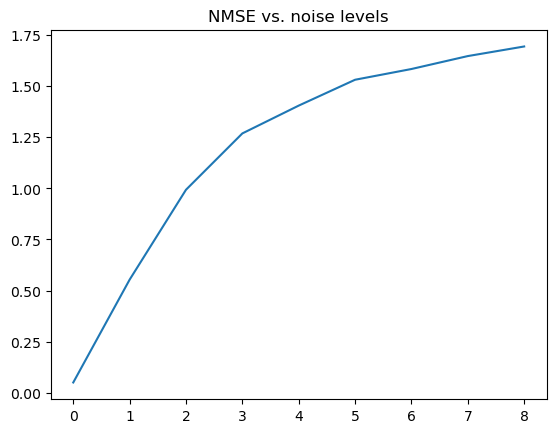

In [24]:
NMSE = lambda x: (((clean_img - x)**2).sum() / (clean_img**2).sum())**1
err = []
for sigma in range(1,10,1):
    noisy_img = clean_img + sigma*np.random.randn(height, width)
    y = noisy_img.copy()
    En, x = ising_learn(y)
    err.append(NMSE(x))
   
plt.title('NMSE vs. noise levels')
plt.plot(err)
plt.show()

Try different parameters in the energy function, e.g., $ h, \beta, \eta$, and  plot the following figures.
1. NMSE vs $ h$
2. NMSE vs $ \beta$
3. NMSE vs $ \eta$

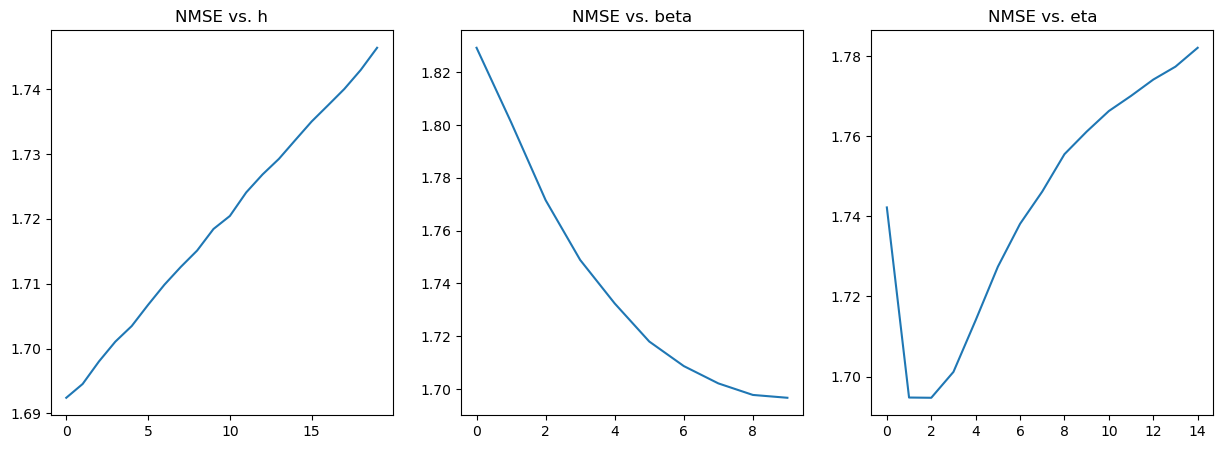

In [25]:
NMSE = lambda x: (((clean_img - x)**2).sum() / (clean_img**2).sum())**1
# set constant as 
sigma = 1
itr = 10
H= []
for h in np.arange(0,2,0.1):
    beta = 1
    eta = 2.1
    y = noisy_img.copy()
    En, x = ising_learn(y)
    H.append(NMSE(x))
        
Beta = []        
for beta in np.arange(0,1,0.1):
    h = 0.1
    eta = 2.1
    y = noisy_img.copy()
    En, x = ising_learn(y)
    Beta.append(NMSE(x))
        
Eta = []
for eta in np.arange(0,15,1):
    h = 0.1
    beta = 1
    y = noisy_img.copy()
    En, x = ising_learn(y)
    Eta.append(NMSE(x))
    
plt.figure(figsize=(15,5))
plt.subplot(131)      
plt.title('NMSE vs. h')
plt.plot(H)
plt.subplot(132)
plt.title('NMSE vs. beta')
plt.plot(Beta)
plt.subplot(133)
plt.title('NMSE vs. eta')
plt.plot(Eta)
plt.show()